# Master NB

Everything up to preprocessing has been done before this notebook.

#### Dependencies

In [21]:
import pandas as pd
import numpy as np
import re

import eli5
from sklearn.feature_extraction import text
from eli5.sklearn import InvertableHashingVectorizer
from gensim.sklearn_api import D2VTransformer
from gensim.test.utils import common_texts
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.feature_extraction import text
from sklearn.pipeline import Pipeline, FeatureUnion
from nltk.tokenize.toktok import ToktokTokenizer

import sys
sys.path.append('../src')

%load_ext autoreload
%autoreload 1

from datatasks.preprocess import tokenize
%aimport datatasks.preprocess

from datatasks.sample_data import sample_data
%aimport datatasks.sample_data
from models.models import evaluate_model, run_models
%aimport models.models
from models.pipeline import make_features_pipeline
from models.plot import plot_confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load Data

In [2]:
DATA_PATH = '../data/'
DATA_INTERIM_PATH = DATA_PATH + 'interim/'
train = pd.read_csv(DATA_INTERIM_PATH + 'train_p.csv')
val = pd.read_csv(DATA_INTERIM_PATH + 'val_p.csv')

#### Sample Data

In [3]:
train_s = sample_data(train, 50000, 'train')
val_s = sample_data(val, 10000, 'val')

#### Store Response Variable

In [4]:
y_train = train_s['hyperpartisan']
y_test = val_s['hyperpartisan']

#### Stopword list

#### Fit very simple model (TFIDF+Logistic Regression)

In [5]:
vec = TfidfVectorizer()
clf = LogisticRegression()

pipeline = Pipeline([
    ('vec', vec),
    ('clf', clf)
])

In [6]:
pipeline.fit(train_s['preprocessed_text'], y_train)

Pipeline(memory=None,
     steps=[('vec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
   ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [7]:
predicted = pipeline.predict(val_s['preprocessed_text'])
evaluate_model(predicted, y_test)

             precision    recall  f1-score   support

      False       0.35      0.64      0.46      2745
       True       0.80      0.55      0.66      7254

avg / total       0.68      0.58      0.60      9999

Accuracy: 0.5782


0.5781578157815782

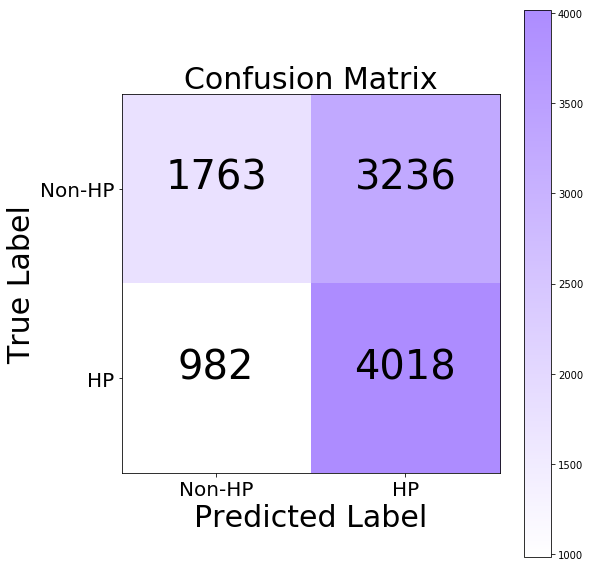

In [8]:
plot_confusion_matrix(y_test, predicted)

#### Observations:

Classifier predicts instances as HP much more than non-HP

#### Examine most important features

In [9]:
eli5.show_weights(clf, vec=vec, top=30)

Weight?,Feature
+21.813,below
+20.336,reading
+16.918,continue
+7.519,opens
+7.031,mr
+6.890,window
+6.378,via
+4.394,here
+3.961,bush
+3.875,fox


#### Examine features which show up much more than expected by publisher

In [45]:
def find_common_context_windows(term, domain, df, df_text_col, window):
    
    series = df[(df['preprocessed_text'].str.contains(' {} '.format(term))) &
           (df['domain']==domain)].reset_index()[df_text_col]
    
    context = []
    
    for text in series:
        text_split = text.split(' ')
        
        indices = [i for i,x in enumerate(text_split) if x == term]
        
        for index in indices:
            context.append([catch(lambda: text_split[index+i]) for i in range(-window, window+1)])
    
    context_df = pd.DataFrame(context)
    
    return context_df

def catch(func, handle=lambda e : e, *args, **kwargs):
    try:
        return func(*args, **kwargs)
    except Exception as e:
        return 'OOR'
    
def examine_top_weights(clf, vec, CONTEXT_THRESH, top_n_domains, n_features):
    weights = eli5.explain_weights_df(clf, vec=vec)
    weights['weight'] = np.absolute(weights['weight'])
    weights.sort_values('weight', inplace=True, ascending=False);
    base_props = train['domain'].value_counts(normalize=True)[0:top_n_domains]
    for i in range(0,n_features): #len(features[0]['tops'][0])):
        row = weights.iloc[i]
        feature = row['feature']
        props = train[(train['preprocessed_text'].str.contains(" {} ".format(feature), regex=False)) &
                     (train['domain'].isin(base_props.keys()))]['domain'].value_counts(normalize=True)
        for key in props.keys():
            if props[key] > 2*base_props[key]:

                # Examine context of term
                context = find_common_context_windows(feature, key, train, 'preprocessed_text', 1)
                forward_context = context[0].value_counts(normalize=True)
                if forward_context[0] > CONTEXT_THRESH:
                    print(feature.upper())
                    print(key, "- Observed: {:.3f}, Expected: {:.3f}, Difference: {:.3f}".format(props[key], base_props[key], props[key]/base_props[key]))
                    print(forward_context[forward_context > CONTEXT_THRESH])
                    print('\n')
                backward_context = context[2].value_counts(normalize=True)
                if backward_context[0] > CONTEXT_THRESH:
                    print(feature.upper())
                    print(key, "- Observed: {:.3f}, Expected: {:.3f}, Difference: {:.3f}".format(props[key], base_props[key], props[key]/base_props[key]))
                    print(backward_context[backward_context > CONTEXT_THRESH])
                    print('\n')

        print('\n')

#### Signatures to Remove

{
'foxbusiness' : ['Continue Reading Below', 'Opens a New Window\.' 'The Motley Fool has a disclosure policy\.', 'The Motley Fool', 'Dow Jones Newswires'],
'inthesetimes' : ['your email \nyour name \nrecipient\(s\) email \(comma separated\) \n \nmessage \ncaptcha'], 'Subscribe to In These Times magazine, or make a tax-deductible donation to fund this reporting.', 'Like what you’ve read\?'],
'truthdig' : ['Associated Press via', 'AP via', 'Read more', 'Reuters via'],
'washingtonblade' : ['\([^)]*\)', 'The Washington Blade'],
'legalinsurrection' : ['\([^)]*\)'],
'feministing' : ['Header image'],
'motherjones' :'[Mother Jones'],
'thedailywire' : ['Daily Wire'],
'factcheck' : ['The FactCheck Wire'],
'abqjournal' : ['New Mexico', 'Santa Fe'],
'newsline' : ['\(UPI\)', 'Fusion Media or anyone involved with Fusion Media will not accept any liability for loss or damage as a result of reliance on the information including data, quotes, charts and buy/sell signals contained within this website\. Please be fully informed regarding the risks and costs associated with trading the financial markets, it is one of the riskiest investment forms possible\.'],
'reuters' : ['Our Standards: \nThe Thomson Reuters Trust Principles\.'],
'thedailybeast' : ['Start and finish your day with the top stories from The Daily Beast\. \nA speedy, smart summary of all the news you need to know \(and nothing you don't\)\.', 'The Daily Beast']
}

ALL - 'advertisement', 'via', 'image', 'source', 'click', 'video', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun', 'mon', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', '___'

In [75]:
removal_dict = {
'foxbusiness' : ['continue reading below', 'opens a new window' 'has no position in any of the stocks mentioned', 'the motley fool has a disclosure policy', 'dow jones newswires', 'copyright marketwatch inc'],
'inthesetimes' : ['your email your name recipients email comma separated message captcha', 'like what youve read subscribe to in these times magazine or make a taxdeductible donation to fund this reporting'],
'truthdig' : ['associated press', 'ap', 'read more', 'reuters'],
'washingtonblade' : ['washington', 'blade'],
'feministing' : ['header image'],
'motherjones' : ['mother jones'],
'thedailywire' : ['daily Wire'],
'factcheck' : ['the factcheck wire'],
'pri' : ['pris'],
'abqjournal' : ['new mexico', 'santa fe', 'albuquerque', 'nm'],
'newsline' : ['upi', 'fusion media or anyone involved with fusion media will not accept any liability for loss or damage as a result of reliance on the information including data quotes charts and buysell signals contained within this website please be fully informed regarding the risks and costs associated with trading the financial markets it is one of the riskiest investment forms possible'],
'reuters' : ['our standards the thomson reuters trust principles'],
'thedailybeast' : ['start and finish your day with the top stories from the daily beast a speedy smart summary of all the news you need to know and nothing you do not', 'the daily beast']
}

stopwords = ['advertisement', 'via', 'image', 'source', 'click', 'video', 'editing', 'investingcom', '___', 'gmt', 'copyright', 'reporting', 'et', 'reprint', 'featured', 'embedded', 'journal',
             'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun', 'mon', 
             'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 
             'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

In [74]:
domain = 'thedailybeast'
term = 'speedy'
t = train[(train['domain']==domain) &
            (train['preprocessed_text'].str.contains(term))].reset_index()['preprocessed_text']

#### Test stopword/sig removal and fit new model

In [76]:
def replace_publisher_signatures(article, removal_dict):
    if article['domain'] in removal_dict.keys():
        for phrase in removal_dict[article['domain']]:
            article['preprocessed_text'] = re.sub(phrase, '', article['preprocessed_text'])
            
    return article

train = train.apply(replace_publisher_signatures, axis=1, args=(removal_dict,))

In [77]:
y_train = train['hyperpartisan']
y_test = val['hyperpartisan']

In [78]:
vec = TfidfVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(stopwords))
clf = LogisticRegression()

pipeline = Pipeline([
    ('vec', vec),
    ('clf', clf)
])
pipeline.fit(train['preprocessed_text'], y_train)
predicted = pipeline.predict(val['preprocessed_text'])
evaluate_model(predicted, y_test)

             precision    recall  f1-score   support

      False       0.37      0.68      0.48     40768
       True       0.83      0.57      0.67    109232

avg / total       0.70      0.60      0.62    150000

Accuracy: 0.5971


0.5971466666666667

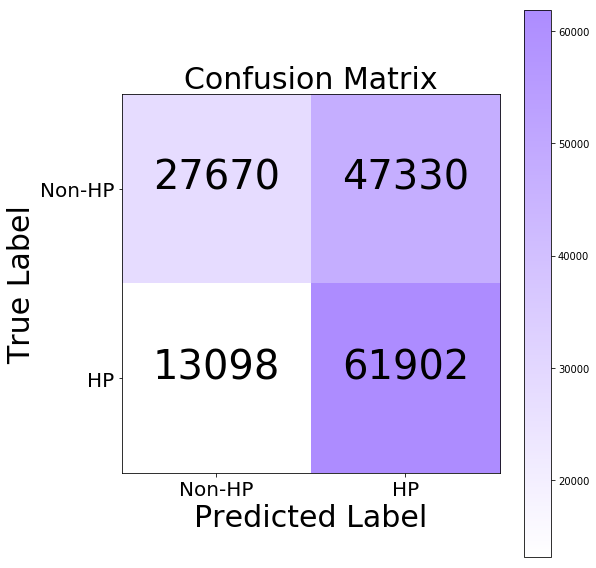

In [79]:
plot_confusion_matrix(y_test, predicted)

In [80]:
eli5.show_weights(clf, vec=vec, top=30)

Weight?,Feature
+19.857,opens
+14.427,ka
+13.785,window
+13.420,ht
+10.895,truthdig
+10.659,jcl
+10.285,wire
+9.931,pzs
+9.729,mr
+8.826,foxbusinesscom


## Improvement from 57.8 to 59.7 - Investigating where it's wrong.

In [81]:
ydf = pd.DataFrame(list(zip(y_test, predicted, val['preprocessed_text'])), 
                   columns=['HP_true', 'predicted', 'preprocessed_text'], index=y_test.index)

In [82]:
ydf.head()

,HP_true,predicted,preprocessed_text
0,False,False,san francisco head of juvenile probation depar...
1,True,True,university leaders ban prolife flag display sa...
2,True,True,donald trump get your tiny piggy pervert hands...
3,True,True,dirty hillary clinton implies trump is a nazi ...
4,False,True,a bipartisan work plan \n american workers con...


In [83]:
incorrect = ydf[~(ydf['HP_true']==ydf['predicted'])].reset_index()
incorrect.shape

(60428, 4)

In [98]:
eli5.explain_prediction(clf, incorrect.iloc[1115]['preprocessed_text'], vec=vec)

Explanation(estimator="LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,\n          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,\n          verbose=0, warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=False, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='said', weight=0.7448510221825979, std=None, value=0.07529822100956543), FeatureWeight(feature='lid', weight=0.3261200440725902, std=None, value=0.08885916018051858), FeatureWeight(feature='boston', weight=0.2649423354835429, std=None, value=0.20603644648217367), FeatureWeight(feature='release', weight=0.2457702598100581, std=None, value=0.06757109277679223), FeatureWeight(feature='authorities', weight=0.18216723921211478, std=None, value=0.11778715607524141), FeatureWeight(feature='city', weight=0.17549559860313832, std=None, value=0.09076427242392432), FeatureWeight(feature='investigators', weight=0.16826323884344913, std=None, value=0.11820165968154903), FeatureWeight(feature='images', weight=0.15298423318050705, std=None, value=0.10287043166568714), FeatureWeight(feature='trace', weight=0.15130253900141982, std=None, value=0.03974378999351904), FeatureWeight(feature='reported', weight=0.13631785366502824, std=None, value=0.03472146012981234), FeatureWeight(feature='recovered', weight=0.1297123943710065, std=None, value=0.06751061534661165), FeatureWeight(feature='marathon', weight=0.12630370980322836, std=None, value=0.16072879355325137), FeatureWeight(feature='cookers', weight=0.12509923349344126, std=None, value=0.2442344352025668), FeatureWeight(feature='according', weight=0.12508210060894273, std=None, value=0.05693254246157772), FeatureWeight(feature='near', weight=0.12123820074330602, std=None, value=0.10384550505481624), FeatureWeight(feature='center', weight=0.09726018901468243, std=None, value=0.03791546079551535), FeatureWeight(feature='pictures', weight=0.08638510395902052, std=None, value=0.06312106856265196), FeatureWeight(feature='letters', weight=0.07869150842447714, std=None, value=0.06402238242314082), FeatureWeight(feature='edge', weight=0.07864405679194711, std=None, value=0.06028226342703503), FeatureWeight(feature='briefing', weight=0.07598282922047905, std=None, value=0.06881627819363005), FeatureWeight(feature='police', weight=0.07029354646060558, std=None, value=0.05761918770464254), FeatureWeight(feature='washington', weight=0.06826393464160464, std=None, value=0.03556928640444287), FeatureWeight(feature='postponed', weight=0.06693497125158003, std=None, value=0.040299542368063455), FeatureWeight(feature='scheduled', weight=0.06586517082599898, std=None, value=0.02605313506754433), FeatureWeight(feature='personnel', weight=0.057765529414896453, std=None, value=0.059487384183104224), FeatureWeight(feature='added', weight=0.05636691731378331, std=None, value=0.019301533763635095), FeatureWeight(feature='associated', weight=0.056217627054446134, std=None, value=0.02237350130644838), FeatureWeight(feature='lawenforcement', weight=0.0514913591823563, std=None, value=0.14524661117678284), FeatureWeight(feature='pellet', weight=0.05107968775183255, std=None, value=0.053955634181854714), FeatureWeight(feature='information', weight=0.047761068165472174, std=None, value=0.018849004754299372), FeatureWeight(feature='alcohol', weight=0.04717292570650527, std=None, value=0.06691597421112733), FeatureWeight(feature='scores', weight=0.0471603207458599, std=None, value=0.031149734777561725), FeatureWeight(feature='surgery', weight=0.04674882729794105, std=None, value=0.03434836744608014), FeatureWeight(feature='injured', weight=0.04626696048342966, std=None, value=0.028176367257037444), FeatureWeight(feature='including', weight=0.04134050923400187, std=None, value=0.030294488990246903), FeatureWeight(feature='richardson', weight=0.04105713809957752, std=Non

### Remov